# Filter fragments for drug likeness

## Aim of this notebook

This notebook is filtering the fragments for drug likeness. The first filter step is to check the fragments properties and check whether they fulfill the Rule of Three ([Ro3](https://www.sciencedirect.com/science/article/abs/pii/S1359644603028319?via%3Dihub)) or not. The other filter calculates the Quantitative Estimate of Druglikeness ([QED](https://www.nature.com/articles/nchem.1243)), reflecting the molecular properties of the fragments.

## Table of contents
* 1. Load fragment library
* 2. Apply pre-filters
* 3. Filter using Ro3
* 4. Filter for Quantitative Estimate of Druglikeness
* 5. Analyse accepted/rejected fragments

In [1]:
from pathlib import Path

import pandas as pd
from rdkit.Chem import PandasTools

from kinfraglib import utils
from kinfraglib import filters

<frozen importlib._bootstrap>:219: RuntimeWarning: to-Python converter for boost::shared_ptr<RDKit::FilterCatalogEntry const> already registered; second conversion method ignored.


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# Needed to display ROMol images in DataFrames
PandasTools.RenderImagesInAllDataFrames(images=True)

## Globals

In [4]:
# Path to data
HERE = Path().resolve()
PATH_DATA = HERE / "../../data"

## 1. Load fragment library

In [5]:
fragment_library = utils.read_fragment_library(PATH_DATA / "fragment_library")

In [6]:
fragment_library.keys()

dict_keys(['AP', 'FP', 'SE', 'GA', 'B1', 'B2', 'X'])

In [7]:
pd.concat(fragment_library).reset_index(drop=True).shape

(7486, 15)

## 2. Apply pre-filters
Pre-filters are 
- removing fragments in pool X
- removing duplicates
- removing fragments without dummy atoms (unfragmented ligands)
- removing fragments only connecting to pool X

In [8]:
fragment_library_pre_filtered = filters.prefilters.pre_filters(fragment_library)

,subpocket,smiles,ROMol,ROMol_dummy,ROMol_original,kinase,family,group,complex_pdb,ligand_pdb,alt,chain,atom_subpockets,atom_environments,smiles_dummy,fragment_count,connections,connections_name
0,AP,Nc1c[nH]c2ncccc12,,,,AAK1,NAK,Other,5l4q,LKB,B,A,AP AP AP AP AP AP AP AP AP AP AP AP AP AP AP F...,16 16 16 16 16 16 16 16 16 16 16 16 16 5 5 na na,[11*]c1cnc2[nH]cc(N[27*])c2c1,3,"[FP, SE]","[AP=FP, AP=SE]"
1,AP,N/C(=C1\C(=O)Nc2ccccc21)c1ccccc1,,,,AAK1,NAK,Other,5te0,XIN,,A,AP AP AP AP AP AP AP AP AP AP AP AP AP AP AP A...,7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 ...,[12*]N/C(=C1\C(=O)Nc2cc([20*])ccc21)c1ccccc1,3,"[SE, GA]","[AP=SE, AP=GA]"
2,AP,Cc1cc(N)[nH]n1,,,,ABL1,Abl,TK,2f4j,VX6,,A,AP AP AP AP AP AP AP AP AP AP AP AP AP SE,5 5 14 14 14 14 14 14 14 8 8 8 8 na,[22*]Nc1cc(C)n[nH]1,9,[SE],[AP=SE]
3,AP,Nc1ncc(C=O)s1,,,,ABL1,Abl,TK,2gqg,1N1,B,A,AP AP AP AP AP AP AP AP AP AP GA SE,14 14 14 6 5 5 14 14 14 6 na na,[15*]Nc1ncc(C([41*])=O)s1,17,"[GA, SE]","[AP=GA, AP=SE]"
4,AP,COCC(=O)n1cc2[nH]nc(NC=O)c2c1,,,,ABL1,Abl,TK,2v7a,627,,B,AP AP AP AP AP AP AP AP AP AP AP AP AP AP AP A...,8 8 8 8 8 5 5 6 6 8 8 8 8 8 8 8 8 8 8 3 3 3 3 ...,[8*]C(=O)Nc1n[nH]c2cn(C(=O)[C@@H]([46*])OC)cc12,3,"[SE, FP]","[AP=SE, AP=FP]"

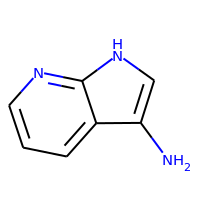
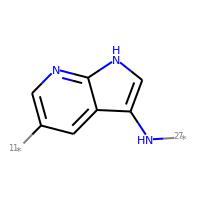
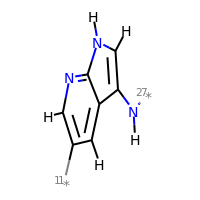
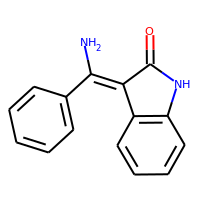
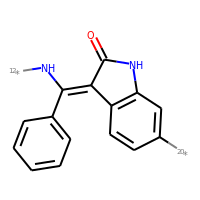
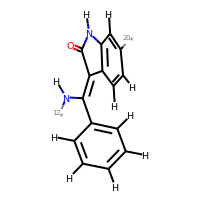
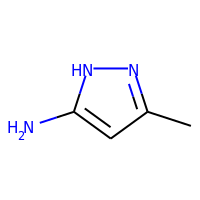
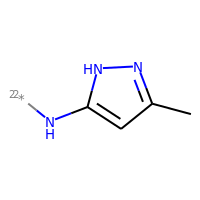
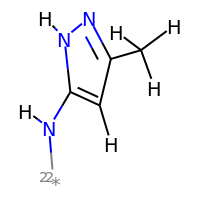
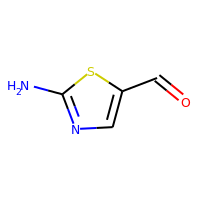
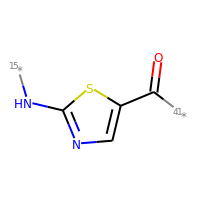
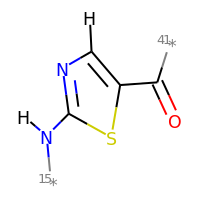
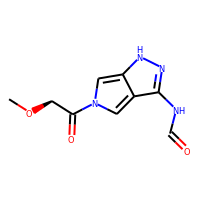
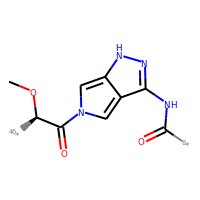
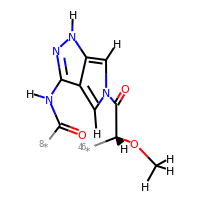

In [9]:
fragment_library_pre_filtered["AP"].head()

In [10]:
df = pd.concat(
    [
        filters.analysis.count_fragments(fragment_library, "original"),
        filters.analysis.count_fragments(fragment_library_pre_filtered, "pre_filtered"),
    ],
    axis=1,
)
df.append(df.sum().rename('Total'))

,original,pre_filtered
subpocket,,
AP,2561,1001
FP,1866,864
SE,1560,607
GA,1024,306
B1,98,42
B2,92,42
Total,7201,2862


For further use we save fragment_library as fragment_library_original and fragment_library_pre_filtered as fragment_library.

In [11]:
fragment_library_original = fragment_library.copy()
fragment_library = fragment_library_pre_filtered.copy()

## 3. Filter for Ro3

The [Rule of Three](https://www.sciencedirect.com/science/article/abs/pii/S1359644603028319?via%3Dihub) is apadted from the [Rule of Five](https://www.sciencedirect.com/science/article/abs/pii/S1056871900001076?via%3Dihub) to check if small molecules make good lead compounds.
It is locking at the molecular properties, namely
- molecular weight (MW) <= 300
- number of hydrogen bond acceptor (HBA) <= 3
- number of hydrogen bond donor (HBD) <= 3
- number of rotatable bonds (NROT) <=3
- polar surface area (PSA) <=60

In [12]:
res = filters.ruleofthree.get_ro3_frags(fragment_library)
ro3_accepted = res["ro3_accepted"]
ro3_rejected = res["ro3_rejected"]
fragment_library_druglikeness = res["fragment_library"]
ro3_vals = res["ro3"]

In [13]:
df = pd.concat(
    [
        filters.analysis.count_fragments(fragment_library, "pre_filtered"),
        filters.analysis.count_accepted_rejected(
            fragment_library_druglikeness, "ro3", "ro3"
        ),
    ],
    axis=1,
)
df.append(df.sum().rename('Total'))

,pre_filtered,accepted_ro3,rejected_ro3
subpocket,,,
AP,1001,516,485
FP,864,655,209
SE,607,501,106
GA,306,278,28
B1,42,39,3
B2,42,40,2
Total,2862,2029,833


## 3. Filter for Quantitative Estimate of Druglikeness (QED)

Quantitative Estimate of Druglikeness ([QED](https://www.nature.com/articles/nchem.1243)) reflects molecular properties (molecular weight, octanol-water-partition-coefficient, number of hydrogen bond donor and acceptor, polar surface area, number of rotatable bonds, number of aromatic rings and number of structural alerts). For each property a desirability function is used and with them the estimate is calculated (QED .

In [14]:
res_qed = filters.qed.get_qed(fragment_library_druglikeness)
qed_accepted = res_qed["qed_accepted"]
qed_rejected = res_qed["qed_rejected"]
fragment_library_druglikeness = res_qed["fragment_library"]
qed_vals = res_qed["qed"]

In [15]:
df = pd.concat(
    [
        filters.analysis.count_fragments(fragment_library, "pre_filtered"),
        filters.analysis.count_accepted_rejected(
            fragment_library_druglikeness, "qed", "qed"
        ),
        filters.analysis.count_accepted_rejected(
            fragment_library_druglikeness, "ro3", "ro3"
        ),
    ],
    axis=1,
)
df.append(df.sum().rename('Total'))

,pre_filtered,accepted_qed,rejected_qed,accepted_ro3,rejected_ro3
subpocket,,,,,
AP,1001,974,27,516,485
FP,864,749,115,655,209
SE,607,548,59,501,106
GA,306,271,35,278,28
B1,42,37,5,39,3
B2,42,39,3,40,2
Total,2862,2618,244,2029,833


## Analysis

,subpocket,smiles,ROMol,ROMol_dummy,ROMol_original,kinase,family,group,complex_pdb,ligand_pdb,alt,chain,atom_subpockets,atom_environments,smiles_dummy,fragment_count,connections,connections_name,ro3,qed
0,AP,Nc1c[nH]c2ncccc12,,,,AAK1,NAK,Other,5l4q,LKB,B,A,AP AP AP AP AP AP AP AP AP AP AP AP AP AP AP F...,16 16 16 16 16 16 16 16 16 16 16 16 16 5 5 na na,[11*]c1cnc2[nH]cc(N[27*])c2c1,3,"[FP, SE]","[AP=FP, AP=SE]",1,1
1,AP,N/C(=C1\C(=O)Nc2ccccc21)c1ccccc1,,,,AAK1,NAK,Other,5te0,XIN,,A,AP AP AP AP AP AP AP AP AP AP AP AP AP AP AP A...,7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 ...,[12*]N/C(=C1\C(=O)Nc2cc([20*])ccc21)c1ccccc1,3,"[SE, GA]","[AP=SE, AP=GA]",1,1
2,AP,Cc1cc(N)[nH]n1,,,,ABL1,Abl,TK,2f4j,VX6,,A,AP AP AP AP AP AP AP AP AP AP AP AP AP SE,5 5 14 14 14 14 14 14 14 8 8 8 8 na,[22*]Nc1cc(C)n[nH]1,9,[SE],[AP=SE],1,1
3,AP,Nc1ncc(C=O)s1,,,,ABL1,Abl,TK,2gqg,1N1,B,A,AP AP AP AP AP AP AP AP AP AP GA SE,14 14 14 6 5 5 14 14 14 6 na na,[15*]Nc1ncc(C([41*])=O)s1,17,"[GA, SE]","[AP=GA, AP=SE]",1,1
4,AP,COCC(=O)n1cc2[nH]nc(NC=O)c2c1,,,,ABL1,Abl,TK,2v7a,627,,B,AP AP AP AP AP AP AP AP AP AP AP AP AP AP AP A...,8 8 8 8 8 5 5 6 6 8 8 8 8 8 8 8 8 8 8 3 3 3 3 ...,[8*]C(=O)Nc1n[nH]c2cn(C(=O)[C@@H]([46*])OC)cc12,3,"[SE, FP]","[AP=SE, AP=FP]",0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996,AP,Oc1cccc(-c2nnc[nH]2)c1,,,,p38a,MAPK,CMGC,5xyy,P0F,,A,AP AP AP AP AP AP AP AP AP AP AP AP AP AP AP A...,14 14 14 14 14 14 16 16 16 16 3 3 16 16 16 16 ...,[14*]c1nnc(-c2cccc(O)c2)[nH]1,1,[GA],[AP=GA],0,1
997,AP,Cn1c(=O)[nH]c2cccnc21,,,,p38a,MAPK,CMGC,6m9l,J9G,,A,AP AP AP AP AP AP AP AP AP AP AP AP AP AP AP A...,9 9 9 9 9 9 8 8 8 9 9 9 9 9 9 9 na na,[7*]Cn1c(=O)[nH]c2cc([36*])cnc21,1,"[GA, SE]","[AP=GA, AP=SE]",1,1
998,AP,CCc1cncnc1,,,,p70S6K,RSK,AGC,3we4,5FI,,A,AP AP AP AP AP AP AP AP AP AP AP AP AP AP AP FP,16 16 16 16 16 16 8 8 8 8 8 8 8 16 16 na,[40*]c1ncncc1CC,8,[FP],[AP=FP],1,1
999,AP,c1ccc2nc3c(cc2c1)CCCCC3,,,,p70S6K,RSK,AGC,3wf8,F76,,A,AP AP AP AP AP AP AP AP AP AP AP AP AP AP AP A...,16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 1...,[12*]c1c2c(nc3ccccc13)CCCCC2,1,[FP],[AP=FP],0,1

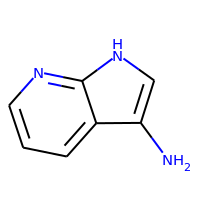
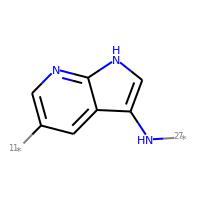
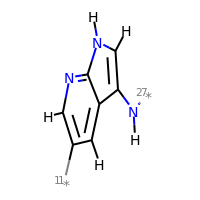
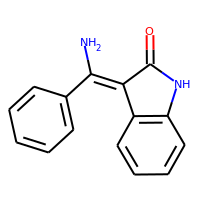
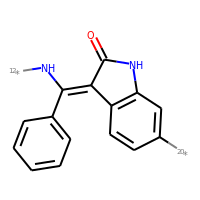
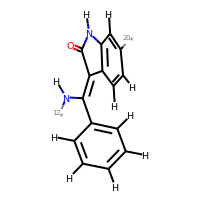
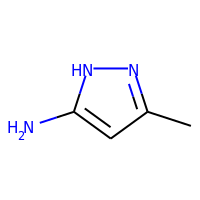
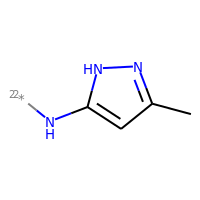
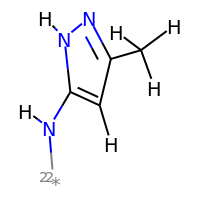
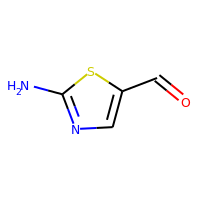
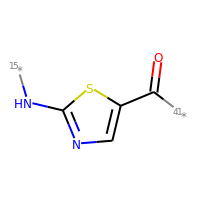
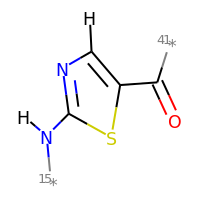
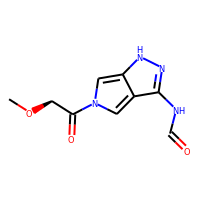
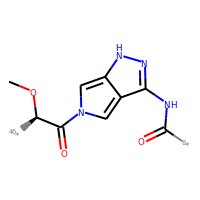
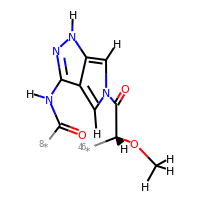
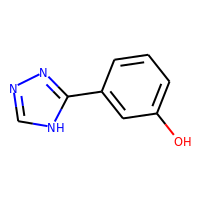
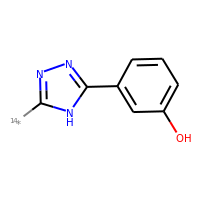
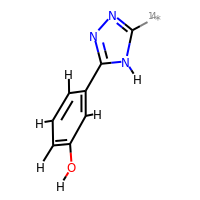
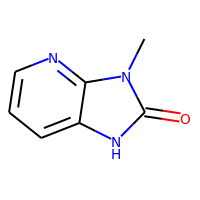
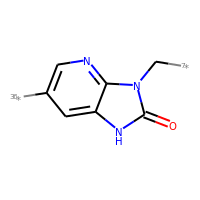
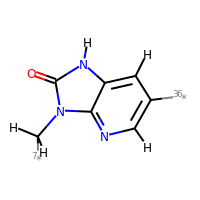
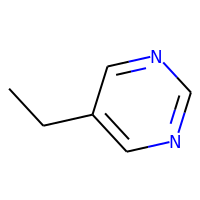
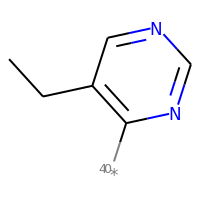
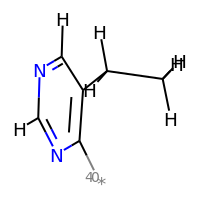
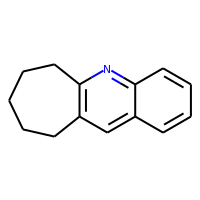
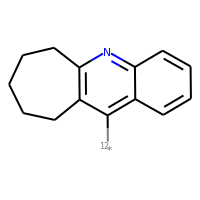
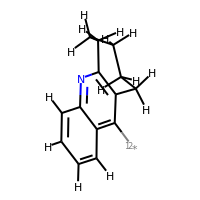
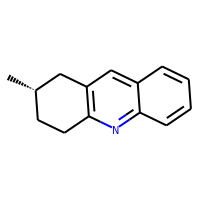
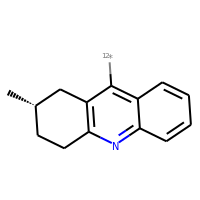
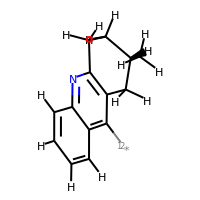

In [16]:
fragment_library_druglikeness["AP"]

In [17]:
fragment_library_druglikeness = filters.analysis.number_of_accepted(
    fragment_library_druglikeness, columns=["ro3", "qed"], min_accepted=2
)

,subpocket,smiles,ROMol,ROMol_dummy,ROMol_original,kinase,family,group,complex_pdb,ligand_pdb,...,chain,atom_subpockets,atom_environments,smiles_dummy,fragment_count,connections,connections_name,ro3,qed,bool
0,AP,Nc1c[nH]c2ncccc12,,,,AAK1,NAK,Other,5l4q,LKB,...,A,AP AP AP AP AP AP AP AP AP AP AP AP AP AP AP F...,16 16 16 16 16 16 16 16 16 16 16 16 16 5 5 na na,[11*]c1cnc2[nH]cc(N[27*])c2c1,3,"[FP, SE]","[AP=FP, AP=SE]",1,1,1
1,AP,N/C(=C1\C(=O)Nc2ccccc21)c1ccccc1,,,,AAK1,NAK,Other,5te0,XIN,...,A,AP AP AP AP AP AP AP AP AP AP AP AP AP AP AP A...,7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 ...,[12*]N/C(=C1\C(=O)Nc2cc([20*])ccc21)c1ccccc1,3,"[SE, GA]","[AP=SE, AP=GA]",1,1,1
2,AP,Cc1cc(N)[nH]n1,,,,ABL1,Abl,TK,2f4j,VX6,...,A,AP AP AP AP AP AP AP AP AP AP AP AP AP SE,5 5 14 14 14 14 14 14 14 8 8 8 8 na,[22*]Nc1cc(C)n[nH]1,9,[SE],[AP=SE],1,1,1
3,AP,Nc1ncc(C=O)s1,,,,ABL1,Abl,TK,2gqg,1N1,...,A,AP AP AP AP AP AP AP AP AP AP GA SE,14 14 14 6 5 5 14 14 14 6 na na,[15*]Nc1ncc(C([41*])=O)s1,17,"[GA, SE]","[AP=GA, AP=SE]",1,1,1
4,AP,COCC(=O)n1cc2[nH]nc(NC=O)c2c1,,,,ABL1,Abl,TK,2v7a,627,...,B,AP AP AP AP AP AP AP AP AP AP AP AP AP AP AP A...,8 8 8 8 8 5 5 6 6 8 8 8 8 8 8 8 8 8 8 3 3 3 3 ...,[8*]C(=O)Nc1n[nH]c2cn(C(=O)[C@@H]([46*])OC)cc12,3,"[SE, FP]","[AP=SE, AP=FP]",0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996,AP,Oc1cccc(-c2nnc[nH]2)c1,,,,p38a,MAPK,CMGC,5xyy,P0F,...,A,AP AP AP AP AP AP AP AP AP AP AP AP AP AP AP A...,14 14 14 14 14 14 16 16 16 16 3 3 16 16 16 16 ...,[14*]c1nnc(-c2cccc(O)c2)[nH]1,1,[GA],[AP=GA],0,1,0
997,AP,Cn1c(=O)[nH]c2cccnc21,,,,p38a,MAPK,CMGC,6m9l,J9G,...,A,AP AP AP AP AP AP AP AP AP AP AP AP AP AP AP A...,9 9 9 9 9 9 8 8 8 9 9 9 9 9 9 9 na na,[7*]Cn1c(=O)[nH]c2cc([36*])cnc21,1,"[GA, SE]","[AP=GA, AP=SE]",1,1,1
998,AP,CCc1cncnc1,,,,p70S6K,RSK,AGC,3we4,5FI,...,A,AP AP AP AP AP AP AP AP AP AP AP AP AP AP AP FP,16 16 16 16 16 16 8 8 8 8 8 8 8 16 16 na,[40*]c1ncncc1CC,8,[FP],[AP=FP],1,1,1
999,AP,c1ccc2nc3c(cc2c1)CCCCC3,,,,p70S6K,RSK,AGC,3wf8,F76,...,A,AP AP AP AP AP AP AP AP AP AP AP AP AP AP AP A...,16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 1...,[12*]c1c2c(nc3ccccc13)CCCCC2,1,[FP],[AP=FP],0,1,0

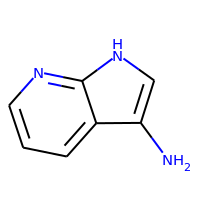
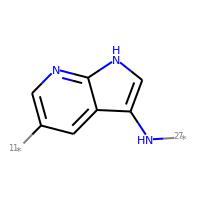
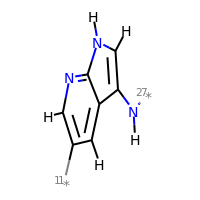
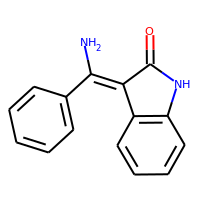
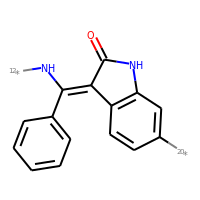
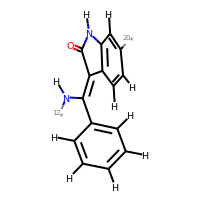
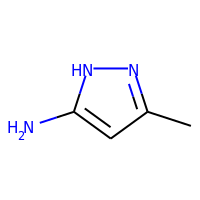
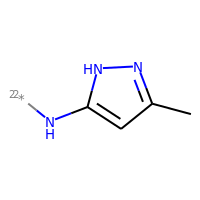
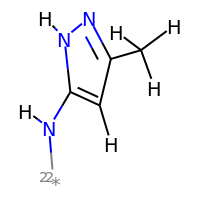
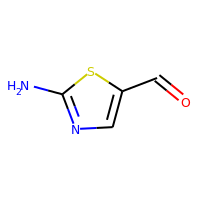
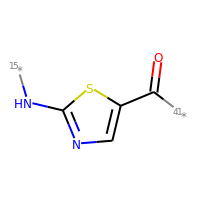
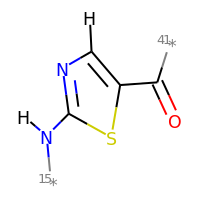
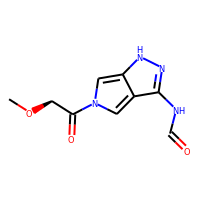
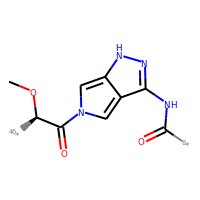
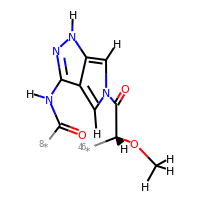
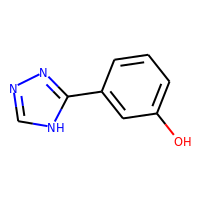
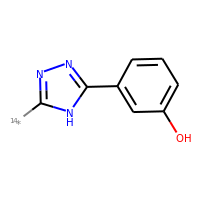
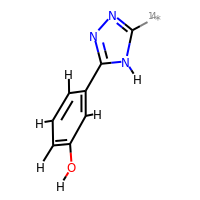
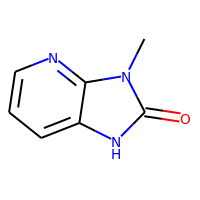
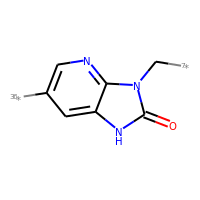
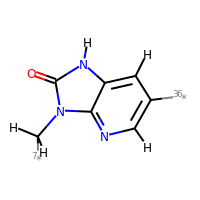
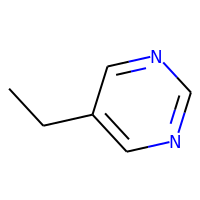
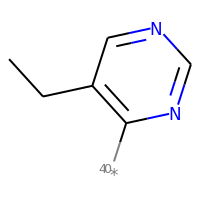
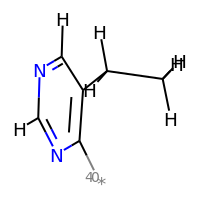
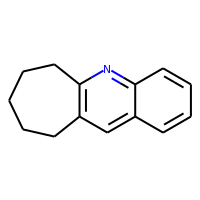
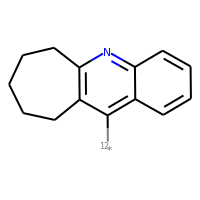
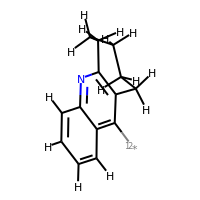
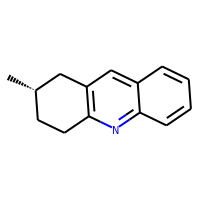
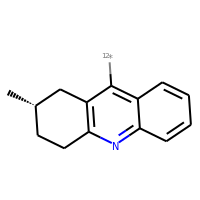
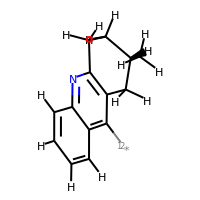

In [18]:
fragment_library_druglikeness["AP"]

In [19]:
df = pd.concat(
    [
        filters.analysis.count_fragments(fragment_library_druglikeness, "pre_filtered"),
        filters.analysis.count_accepted_rejected(
            fragment_library_druglikeness, "bool", "both"
        ),
    ],
    axis=1,
)
df.append(df.sum().rename('Total'))

,pre_filtered,accepted_both,rejected_both
subpocket,,,
AP,1001,507,494
FP,864,567,297
SE,607,455,152
GA,306,249,57
B1,42,34,8
B2,42,37,5
Total,2862,1849,1013


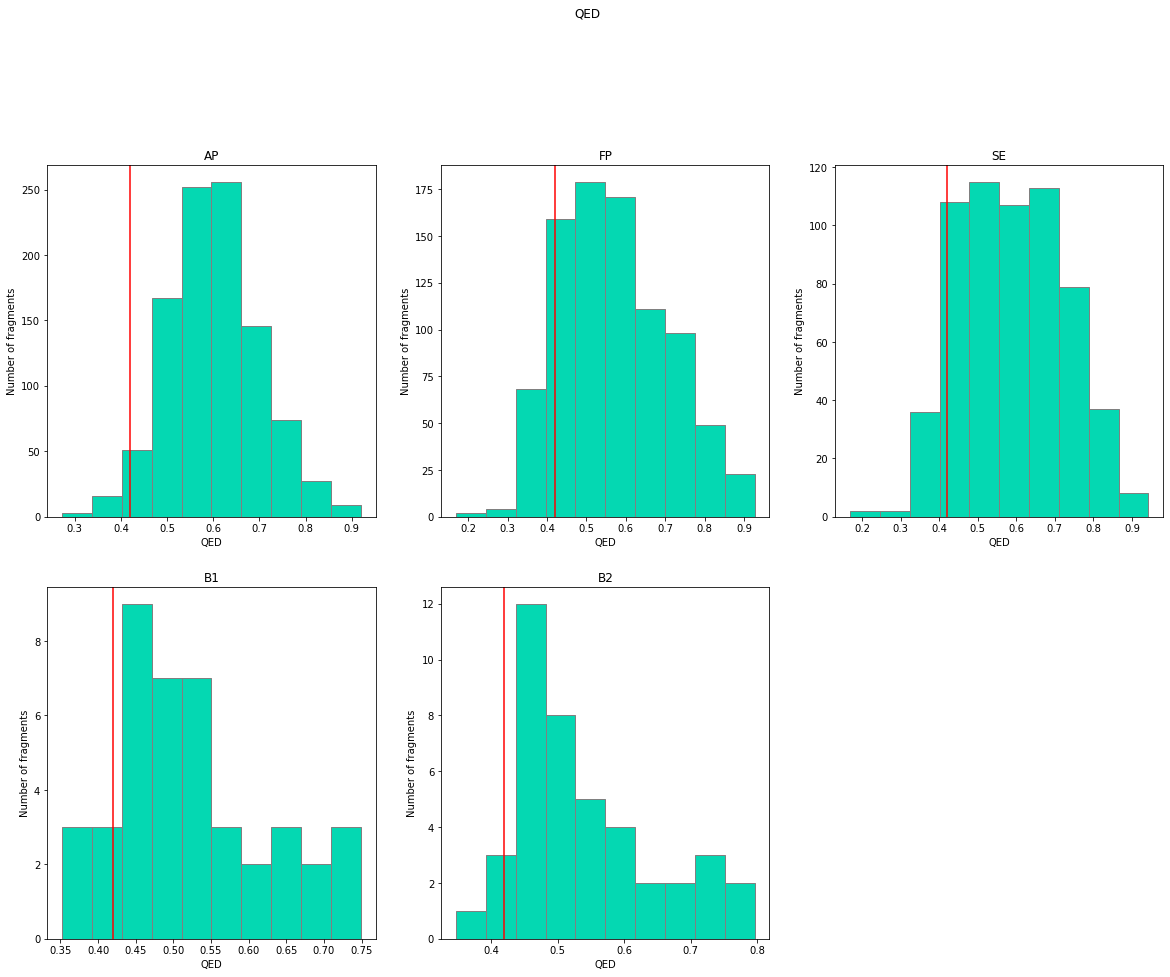

In [20]:
filters.plots.make_hists(
    qed_vals, fragment_library_druglikeness, "QED", plot_stats=False, cutoff=0.42
)